In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import optuna

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, MACCSkeys, AllChem

import warnings
warnings.filterwarnings('ignore')


In [12]:

print("데이터 로딩 중...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"훈련 데이터 : {train.shape}")
print(f"테스트 데이터 : {test.shape}")

데이터 로딩 중...
훈련 데이터 : (1681, 3)
테스트 데이터 : (100, 2)


In [13]:

def get_molecule_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0] * 2232

        basic_descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.NumAliphaticRings(mol),
            Lipinski.NumAromaticHeterocycles(mol),
            Lipinski.NumSaturatedHeterocycles(mol),
            Lipinski.NumAliphaticHeterocycles(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.RingCount(mol),
            Descriptors.NOCount(mol),
            Descriptors.NHOHCount(mol),
            Descriptors.NumRadicalElectrons(mol),
        ]

        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        morgan_features = [int(bit) for bit in morgan_fp.ToBitString()]

        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        maccs_features = [int(bit) for bit in maccs_fp.ToBitString()]

        all_features = basic_descriptors + morgan_features + maccs_features

        return all_features
    except:
        return [0] * 2232


## 분자 특성 추출 및 데이터 전처리 과정

이 단계에서는 SMILES 문자열을 분자 특성으로 변환하고, 머신러닝 모델에 입력할 수 있는 형태로 데이터를 준비합니다.

### 처리 과정:
1. **특성 추출**: 각 SMILES를 2232차원의 특성 벡터로 변환
2. **길이 통일**: 모든 특성 벡터의 길이를 동일하게 맞춤
3. **배열 변환**: 리스트를 NumPy 배열로 변환
4. **차원 정합**: 훈련/테스트 데이터의 특성 차원을 일치시킴

In [14]:
print("분자 특성 추출 중...")

# 1. 훈련 데이터 특성 추출
# SMILES를 분자 특성으로 변환 (각 행에 대해 get_molecule_descriptors 함수 적용)
train['features'] = train['Canonical_Smiles'].apply(get_molecule_descriptors)

# 2. 훈련 데이터 길이 통일
# features 컬럼의 리스트들을 파이썬 리스트로 변환
X_train_list = train['features'].tolist()
# 각 특성 벡터의 길이 확인
feature_lengths = [len(x) for x in X_train_list]

# 만약 특성 벡터들의 길이가 다르다면 (이론적으로는 모두 2232여야 함)
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    # 짧은 벡터들을 0으로 패딩하여 길이를 맞춤
    X_train_list = [x + [0] * (max_length - len(x)) for x in X_train_list]

# 3. NumPy 배열로 변환
X_train = np.array(X_train_list)  # (샘플 수, 특성 수) 형태의 2D 배열
y_train = train['Inhibition'].values  # 타겟 변수

# 4. 테스트 데이터 특성 추출 (훈련 데이터와 동일한 과정)
test['features'] = test['Canonical_Smiles'].apply(get_molecule_descriptors)
X_test_list = test['features'].tolist()
feature_lengths = [len(x) for x in X_test_list]

# 테스트 데이터도 길이 통일
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    X_test_list = [x + [0] * (max_length - len(x)) for x in X_test_list]

# 5. 훈련/테스트 데이터 간 차원 정합
# 만약 훈련과 테스트 데이터의 특성 수가 다르다면
if X_train.shape[1] != len(X_test_list[0]):
    diff = abs(X_train.shape[1] - len(X_test_list[0]))
    if X_train.shape[1] > len(X_test_list[0]):
        # 훈련 데이터가 더 크면 테스트 데이터를 패딩
        X_test_list = [x + [0] * diff for x in X_test_list]
    else:
        # 테스트 데이터가 더 크면 훈련 데이터를 패딩
        X_train = np.array([x.tolist() + [0] * diff for x in X_train])

# 6. 최종 테스트 데이터 배열 변환
X_test = np.array(X_test_list)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 {X_train.shape[1]}개")


분자 특성 추출 중...


[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerator
[22:53:20] DEPRECATION WARNING: please use MorganGenerat

X_train: (1681, 2233), X_test: (100, 2233)
특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 2233개


[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerator
[22:53:26] DEPRECATION WARNING: please use MorganGenerat

In [15]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42
)


In [ ]:

def normalized_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true) - np.min(y_true))

def pearson_correlation(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return np.clip(corr, 0, 1)

def competition_score(y_true, y_pred):
    nrmse = min(normalized_rmse(y_true, y_pred), 1)
    pearson = pearson_correlation(y_true, y_pred)
    return 0.5 * (1 - nrmse) + 0.5 * pearson

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_nrmse = normalized_rmse(y_val, y_val_pred)
    val_pearson = pearson_correlation(y_val, y_val_pred)
    val_score = competition_score(y_val, y_val_pred)
    print(f"검증 NRMSE: {val_nrmse:.4f}")
    print(f"검증 Pearson: {val_pearson:.4f}")
    print(f"검증 점수: {val_score:.4f}")
    return model, val_score

# Optuna를 위한 objective 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),  # 더 넓게
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),  # log scale이 더 적합
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        # colsample_bylevel 생략하거나 고정 가능
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'random_state': 42
    }

    
    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()


In [ ]:
# Optuna 최적화 실행
print("XGBRegressor 하이퍼파라미터 최적화 시작...")
study = optuna.create_study(direction='maximize')  # neg_mean_squared_error를 최대화
study.optimize(objective, n_trials=100)

print(f"최적 파라미터: {study.best_params}")
print(f"최적 점수 (neg_MSE): {study.best_value:.4f}")
print(f"최적 MSE: {-study.best_value:.4f}")

# 최적 하이퍼파라미터로 모델 훈련
best_params = study.best_params
best_params.update({
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': 42,
    'n_jobs': -1
})

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_final, y_train_final)

# 검증 데이터로 성능 평가
y_val_pred = best_model.predict(X_val)

val_nrmse = normalized_rmse(y_val, y_val_pred)
val_pearson = pearson_correlation(y_val, y_val_pred)
val_score = competition_score(y_val, y_val_pred)

print(f"\n검증 데이터 성능:")
print(f"검증 NRMSE: {val_nrmse:.4f}")
print(f"검증 Pearson: {val_pearson:.4f}")
print(f"검증 점수: {val_score:.4f}")


[I 2025-07-05 22:53:26,570] A new study created in memory with name: no-name-f1631495-a49f-4cb7-af15-f88267024b82


XGBRegressor 하이퍼파라미터 최적화 시작...


[I 2025-07-05 22:53:45,803] Trial 0 finished with value: -658.9376745734318 and parameters: {'n_estimators': 527, 'max_depth': 10, 'learning_rate': 0.25260185885127256, 'subsample': 0.8717965266915769, 'colsample_bytree': 0.8206095414023566, 'colsample_bylevel': 0.9122105323181551, 'min_child_weight': 8, 'gamma': 0.4450850238227014, 'reg_alpha': 0.8311363103418243, 'reg_lambda': 0.8137109557367862}. Best is trial 0 with value: -658.9376745734318.
[I 2025-07-05 22:53:51,343] Trial 1 finished with value: -701.6950955045043 and parameters: {'n_estimators': 223, 'max_depth': 3, 'learning_rate': 0.2965884274329588, 'subsample': 0.6214030111236395, 'colsample_bytree': 0.9463015650505385, 'colsample_bylevel': 0.6072797726823076, 'min_child_weight': 2, 'gamma': 0.09844564576925535, 'reg_alpha': 0.7351993293666008, 'reg_lambda': 1.061794782608377}. Best is trial 0 with value: -658.9376745734318.
[I 2025-07-05 22:54:11,553] Trial 2 finished with value: -607.1125178394766 and parameters: {'n_esti

In [ ]:
# 최종 모델로 전체 데이터 학습 및 예측
print("\n전체 데이터로 최종 모델 훈련 중...")
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_scaled, y_train)




전체 데이터로 최종 모델 훈련 중...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,0.6526360435989724
,colsample_bynode,None
,colsample_bytree,0.7177226271259342
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
test_preds = final_model.predict(X_test_scaled)

# 결과 저장
submission['Inhibition'] = test_preds
submission.to_csv('xgboost_optuna_submission.csv', index=False)
print("예측 결과 저장: xgboost_optuna_submission.csv")


예측 결과 저장: xgboost_optuna_submission.csv


모델 성능 시각화 저장: xgboost_model_performance.png
특성 중요도 시각화 저장: xgboost_feature_importance.png

최종 결과:
검증 점수: nan


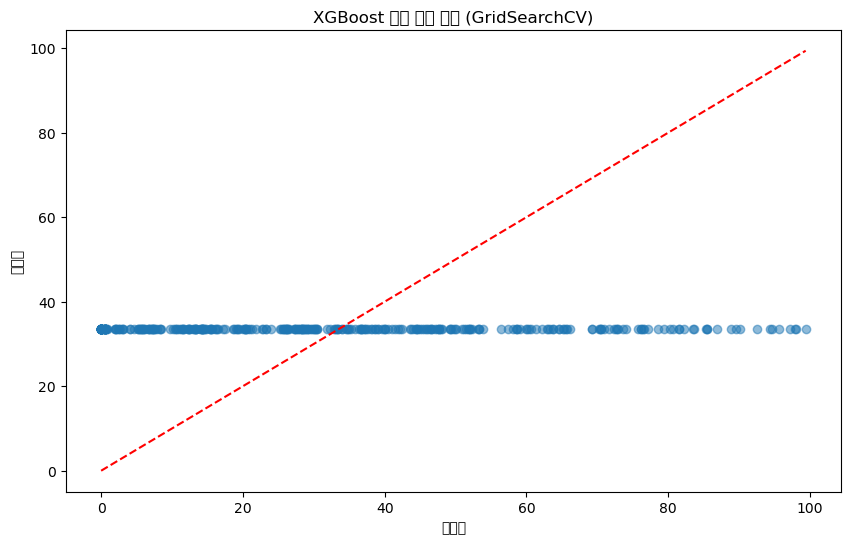

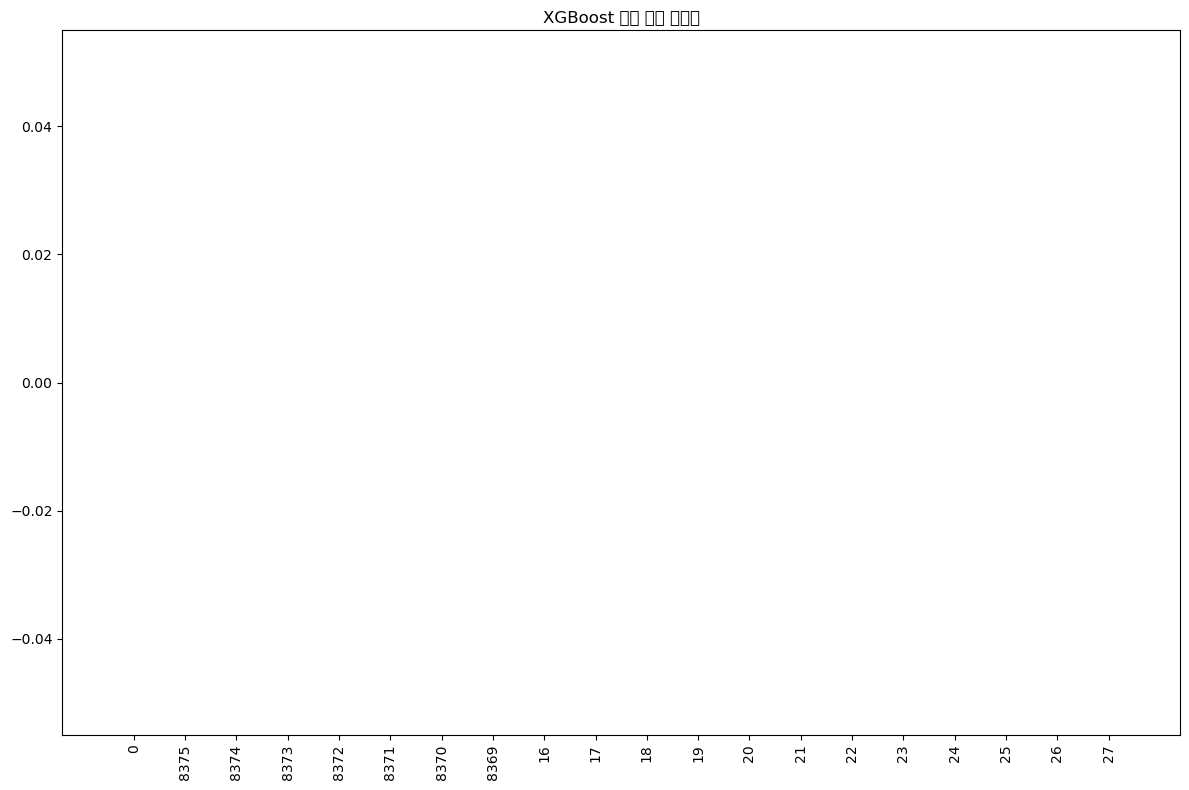

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('XGBoost 모델 검증 성능 (GridSearchCV)')
plt.savefig('xgboost_model_performance.png')
print("모델 성능 시각화 저장: xgboost_model_performance.png")

# 특성 중요도 시각화
n_features = 20
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:n_features]
plt.figure(figsize=(12, 8))
plt.title('XGBoost 상위 특성 중요도')
plt.bar(range(n_features), importances[indices])
plt.xticks(range(n_features), indices, rotation=90)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
print("특성 중요도 시각화 저장: xgboost_feature_importance.png")

print(f"\n최종 결과:")
print(f"검증 점수: {val_score:.4f}")